# Batch machine learning pipeline

## OUTLINE:
* dataset preprocessing
* classification pipeline - Random Forest
* results improvement
* feautre engineering  
dataset : TEP

<img src="./images/batch_scenario.png" alt="drawing" width="1000"/>

## Random Forest
<img src="./images/random_forest.png" alt="drawing" width="500"/>
    
    [1] Verikas, Antanas, et al. "Electromyographic patterns during golf swing: Activation sequence profiling and prediction of shot effectiveness." Sensors 16.4 (2016): 592.

## libraries

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skfeature.function.similarity_based import lap_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

#import xgboost

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import glob
import pandas as pd
import numpy as np
from random import randrange

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Create a Workshop TEP dataset wih imbalanced classes for batch learning

In [66]:
# drop_indices = []
# for fault in dataset['fault_id'].unique():
#     min_index = dataset[dataset['fault_id']==fault].index.min()
#     max_index = dataset[dataset['fault_id']==fault].index.max()
#     a = randrange(min_index, max_index)
#     b = randrange(min_index, max_index)
#     if a<b:
#         to_drop = np.arange(a,b)
#     else:
#         to_drop = np.arange(b,a)
#     drop_indices.extend(to_drop)

In [68]:
# dataset = pd.read_csv('dataset.csv', index_col=False)
# dataset.drop(drop_indices).to_csv('workshop_dataset.csv', index=False)
# dataset.iloc[drop_indices].to_csv('workshop_dataset_stream_testing.csv', index=False)

# 1. Preprocessing

In [2]:
dataset = pd.read_csv('workshop_dataset.csv',index_col=False)
col_names = dataset.columns.tolist()

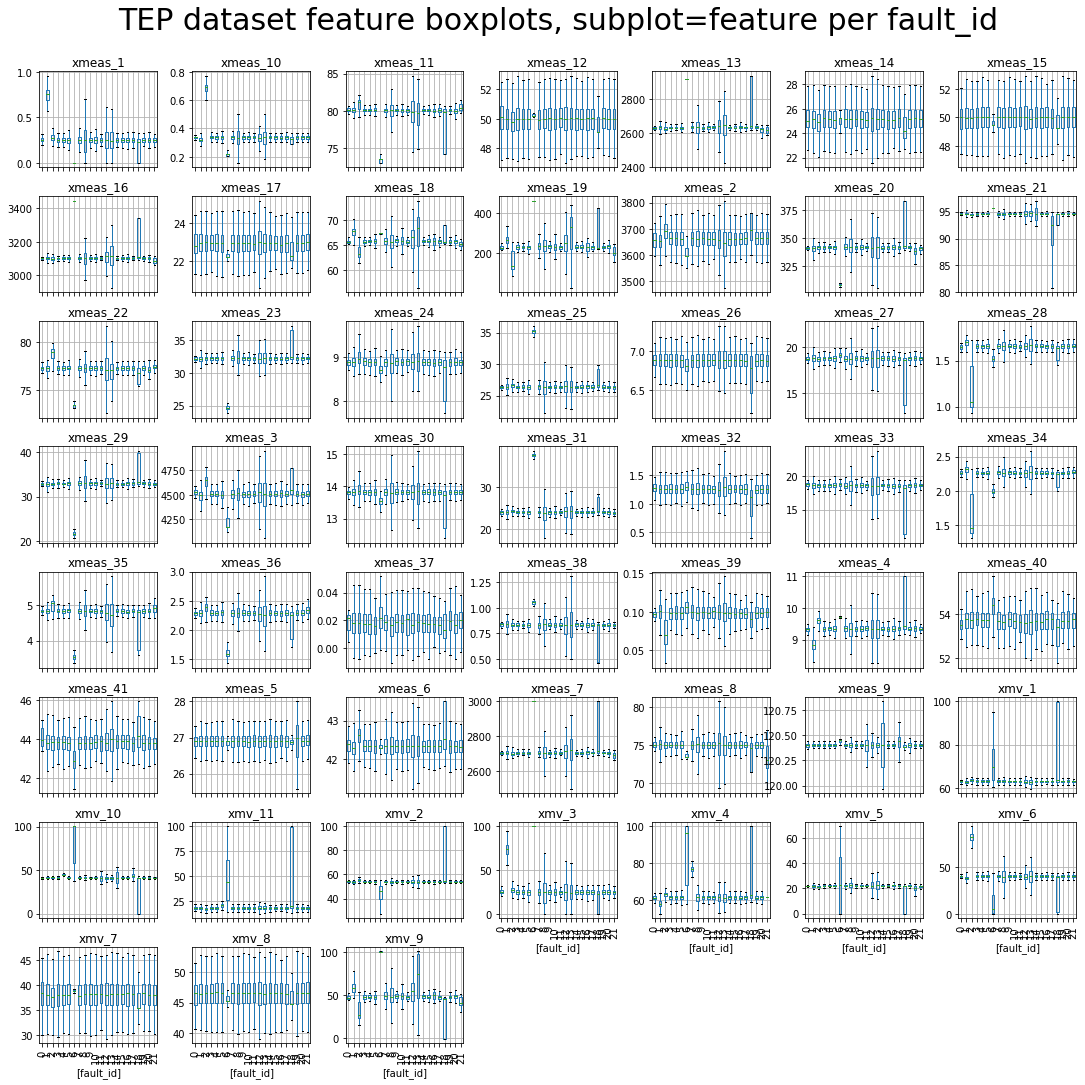

In [3]:
fig, ax = plt.subplots(8,7, figsize=(18, 18))
[fig.delaxes(ax[7,i]) for i in [3,4,5,6]]
ax = np.delete(ax.flatten(), [52,53,54,55])
dataset.boxplot(ax=ax, by='fault_id', rot=90, showfliers=False)
[ax.set_xlabel('') for ax in ax.flatten()[:-7]]
[ax.set_xticklabels([]) for ax in ax.flatten()[:-7]]
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle("TEP dataset feature boxplots, subplot=feature per fault_id", size=30, y=0.95);

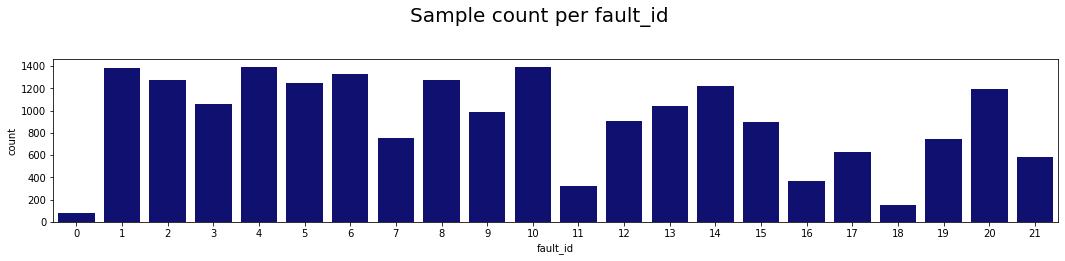

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Sample count per fault_id', size=20, y=1.12)
sns.countplot(ax = ax, x='fault_id', data=dataset,color='navy');

## 1.2. Class imbalance impact

In [5]:
# define undersample strategy
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
# 'not minority' = resample all classes to the size of minority class
undersample = RandomUnderSampler(sampling_strategy='not minority')
oversample = RandomOverSampler(sampling_strategy='not majority')

dataset_under_values, labels_under = undersample.fit_resample(dataset.drop(columns=['fault_id']), dataset['fault_id'])
dataset_under = pd.DataFrame(np.concatenate([dataset_under_values, labels_under.reshape(-1,1)], axis=1), columns = col_names)
dataset_under['type'] = 'under'
dataset_over_values, labels_over = oversample.fit_resample(dataset.drop(columns=['fault_id']), dataset['fault_id'])
dataset_over = pd.DataFrame(np.concatenate([dataset_over_values, labels_over.reshape(-1,1)], axis=1), columns = col_names)
dataset_over['type'] = 'over'

dataset['type'] = 'original'

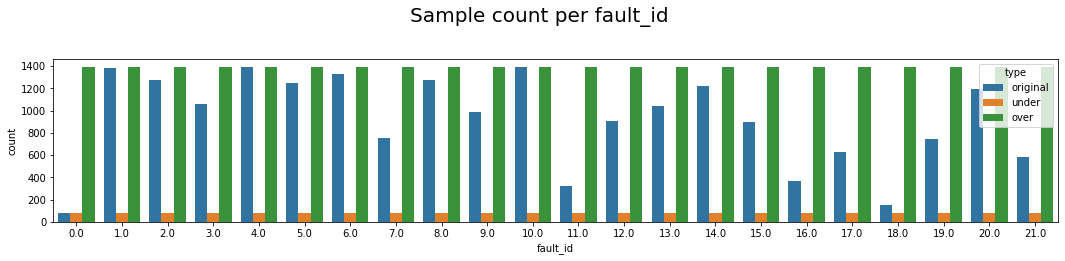

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Sample count per fault_id', size=20, y=1.12)
sns.countplot(ax = ax, x='fault_id', data=pd.concat([dataset, dataset_under, dataset_over], ignore_index=True), hue='type');

In [7]:
def scale_dataset(dataset):
    scaler = StandardScaler()
    scaler.fit(dataset.drop(columns=['fault_id', 'type']))
    dataset_scaled = pd.DataFrame(scaler.transform(dataset.drop(columns=['fault_id', 'type'])),columns=col_names[:-1])
    dataset_scaled['fault_id'] = dataset['fault_id'].copy()
    return dataset_scaled

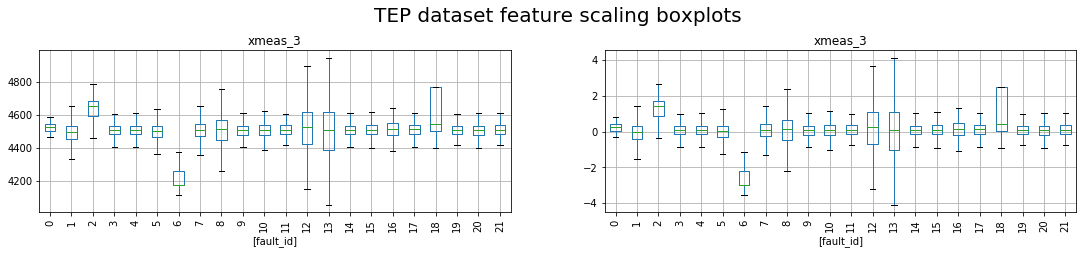

In [8]:
feature = 'xmeas_3'
ds = dataset.copy()

fig, ax = plt.subplots(1,2, figsize=(18, 3))
ds[[feature, 'fault_id']].boxplot(ax=ax[0], rot=90, by='fault_id', showfliers=False)
scale_dataset(ds)[[feature, 'fault_id']].boxplot(ax=ax[1], rot=90, by='fault_id', showfliers=False)
fig.suptitle("TEP dataset feature scaling boxplots", size=20, y=1.1);

# 2. Classification pipeline

## 2.1. Pipeline

In [9]:
pipe = Pipeline([('balancer',RandomOverSampler()), 
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier())])
#('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))

## 2.2. Results

In [10]:
X = dataset.dropna().drop(columns=['fault_id','type'])
Y = dataset.dropna()['fault_id']
scores = cross_val_score(pipe, X, Y, cv=10)
print('10-Cross-Validation scores :\n' + str(scores))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
pipe.fit(X_train, Y_train)
feature_importances = pipe.named_steps['classifier'].feature_importances_
print('Classification report :\n' + str(classification_report(Y_test, pipe.predict(X_test))))

10-Cross-Validation scores :
[0.59202756 0.70246305 0.68506654 0.52       0.31472332 0.64950495
 0.67178218 0.65923725 0.68037661 0.70223325]
Classification report :
              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.94      0.88      0.91       130
           2       0.93      0.87      0.90       134
           3       0.43      0.66      0.52       113
           4       0.90      0.89      0.89       149
           5       0.63      0.73      0.68       105
           6       0.95      0.92      0.93       144
           7       1.00      1.00      1.00        74
           8       0.91      0.92      0.92       147
           9       0.56      0.60      0.58        93
          10       0.75      0.80      0.77       128
          11       0.86      0.68      0.76        28
          12       0.97      0.95      0.96        96
          13       1.00      0.99      0.99        97
          14       0.93

# 3. Improving results

## 3.1. Results Analysis

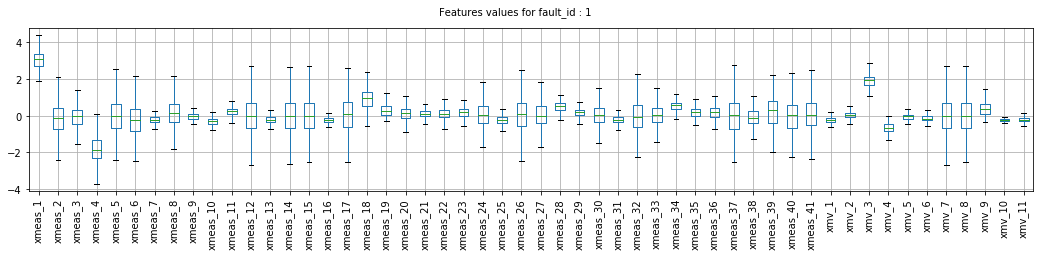

In [11]:
ds = scale_dataset(dataset)
fault_id = 1

fig, ax = plt.subplots(1,1, figsize=(18, 3))
ds[ds['fault_id']==fault_id].drop(columns=['fault_id']).boxplot(ax=ax, rot=90, showfliers=False)
fig.suptitle('Features values for fault_id : ' + str(fault_id), size=10);

## 3.2. Parameter calibration

In [ ]:
# "classifier__" string same as in pipeline
param_grid = [{'classifier__n_estimators': [100, 200, 500],
               'classifier__max_features': ['auto', 'log2'],
               'classifier__max_depth' : [5,10,50,100,None],
               'classifier__criterion' :['gini', 'entropy']}]

RF_clf_gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted',n_jobs=4, cv=10)
RF_clf_gs.fit(dataset.drop(columns=['fault_id','type']), dataset['fault_id'])
means = RF_clf_gs.cv_results_['mean_test_score']
stds = RF_clf_gs.cv_results_['std_test_score']
print('RF 10CV f1 score mean with 95% confidence interval : ')
for mean, std, params in zip(means, stds, RF_clf_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

## 3.3. Feature Engineering

### 3.3.1. Feature Selection

#### 3.3.1.1. Feature importance (RandomForest, XGBoost)

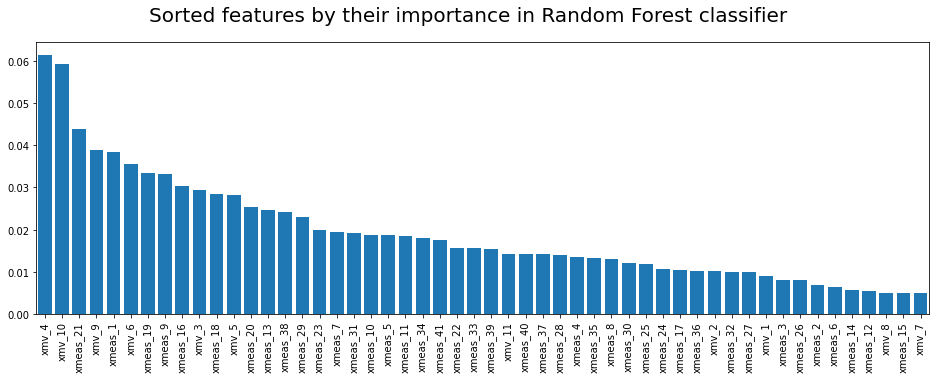

In [79]:
feature_names = [col_names[i] for i in np.argsort(feature_importances)]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
fig.suptitle('Sorted features by their importance in Random Forest classifier', size=20)
ax.bar(np.arange(len(feature_importances)), np.sort(feature_importances)[::-1])
ax.tick_params(labelsize=10)
ax.set_xlim([-0.5, len(feature_importances)-0.5])
ax.set_xticks(np.arange(len(feature_importances)))
ax.set_xticklabels(feature_names[::-1], rotation=90);

#### 3.3.1.2. Feature correlation

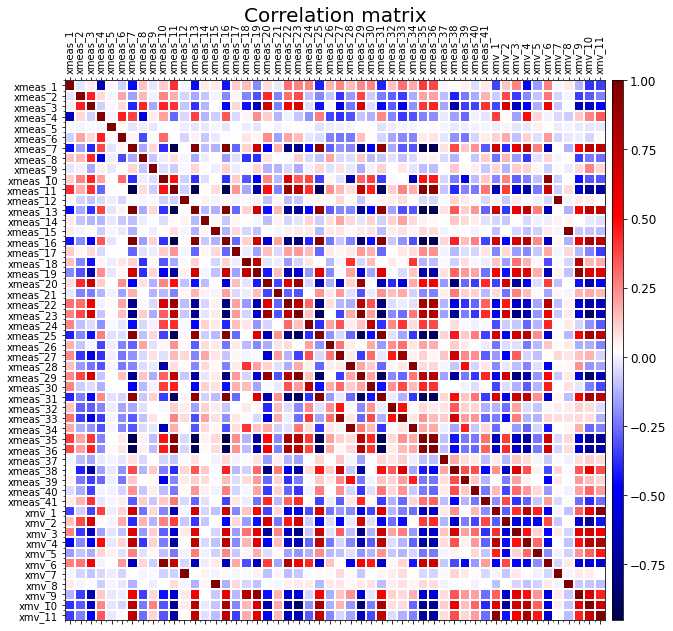

In [80]:
def corr_heatmap(dataset, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.suptitle(title, size=20);
    heatmap = ax.matshow(dataset, cmap=plt.cm.seismic)
    ax.set_xticks(range(dataset.shape[1]))
    ax.set_xticklabels(dataset.columns.values, fontsize=10, rotation=90)
    ax.set_yticks(range(dataset.shape[0]))
    ax.set_yticklabels(dataset.index.values, fontsize=10)

    ax.set_xticks(np.arange(-.5, dataset.shape[1]-1, 1), minor=True);
    ax.set_yticks(np.arange(-.5, dataset.shape[0]-1, 1), minor=True);
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2.)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)

    cb = fig.colorbar(heatmap, cax=cax)
    cb.ax.tick_params(labelsize=12)
    
# do not correlate fault_ids and type :)
ds = dataset.copy()
dataset_corr = ds.drop(columns=['fault_id', 'type']).corr()
corr_heatmap(dataset_corr, 'Correlation matrix');

#### 3.3.1.3. Feature correlation - Improved

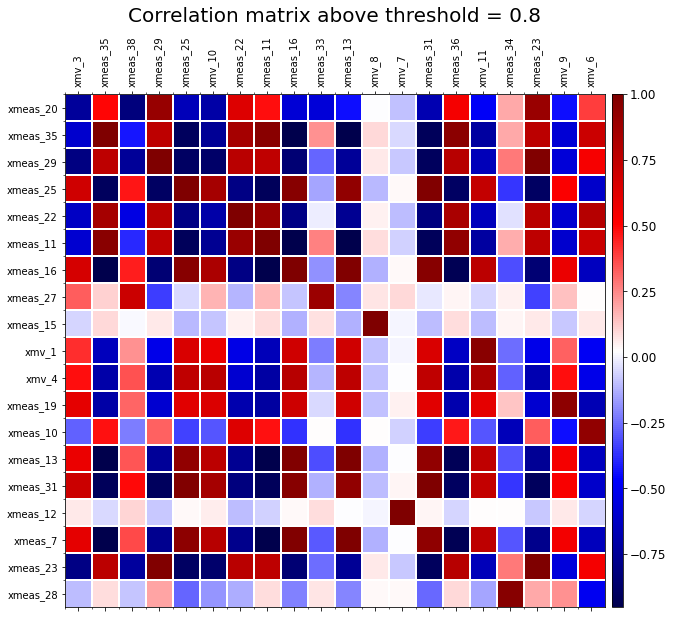

In [81]:
ds = dataset.copy()
dataset_corr = ds.drop(columns=['fault_id', 'type']).corr()
correlation_threshold = 0.8

upper = dataset_corr.where(np.triu(np.ones(dataset_corr.shape), k = 1).astype(np.bool))
# Select the features with correlations above the threshold
# absolute value - positive/negative correlation
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

# Dataframe to hold correlated pairs
dataset_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

# Iterate through the "columns to drop" to record pairs of correlated features
for column in to_drop:

    # Find the correlated features
    corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

    # Find the correlated values
    corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(corr_features))]    

    # Record the information (need a temp df for now)
    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                     'corr_feature': corr_features,
                                     'corr_value': corr_values})
    dataset_collinear = dataset_collinear.append(temp_df, ignore_index = True)
    
dataset_corr_filtered = dataset_corr.loc[list(set(dataset_collinear['corr_feature'])), list(set(dataset_collinear['drop_feature']))]

corr_heatmap(dataset_corr_filtered, 'Correlation matrix above threshold = ' + str(correlation_threshold));

#### 3.3.1.4. Feature variance(entropy)

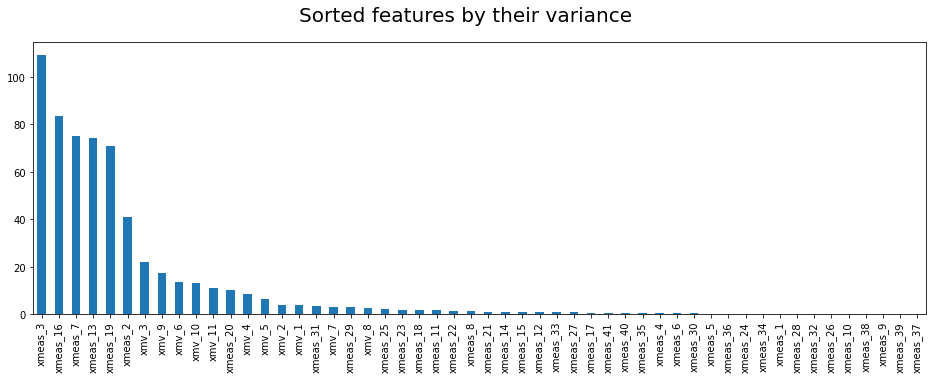

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
fig.suptitle('Sorted features by their variance', size=20)
ds.drop(columns=['fault_id', 'type']).std().sort_values(ascending=False).plot.bar();

#### 3.3.1.5. Other feature selection methods
http://featureselection.asu.edu/  
http://featureselection.asu.edu/algorithms.php

In [ ]:
dataset_lap_score = lap_score.lap_score(ds.drop(columns=['fault_id', 'type']).values)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.bar(np.arange(len(dataset_lap_score)), np.sort(dataset_lap_score)[::-1])
ax.tick_params(labelsize=10)
ax.set_xlim([-0.5, len(ds)-0.5])
ax.set_xticks(np.arange(len(dataset_lap_score)))
ax.set_xticklabels([col_names[i] for i in np.argsort(dataset_lap_score)][::-1], rotation=90)

### 3.3.2. Secondary feature creation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [10]:
#quantile(), std(), mean(), median(), min(), max()
dataset['new'] = dataset['xmeas_1'].rolling(10).mean()
# .diff()